<a href="https://colab.research.google.com/github/kuir-juach/MLOP_pipeline_summatives/blob/main/Pipeline_summatives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [ ]:
#Data Loading
data = pd.read_csv("/content/School_dataset.csv")

In [ ]:

print("Column names in the dataset:", data.columns)

Column names in the dataset: Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 

In [ ]:
#Data Preprocessing
print("Missing values:\n", data.isnull().sum())
numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(include=["object"]).columns

#Filling missing values
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)


Missing values:
 Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                  

<ipython-input-4-7a1eaaba0926>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)


In [ ]:
# One-hot encoding for categorical variables
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(drop="first", sparse_output=False)
    encoded_cols = encoder.fit_transform(data[categorical_cols])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))
    data = data.drop(categorical_cols, axis=1)
    data = pd.concat([data, encoded_df], axis=1)

target_column = 'Target_Enrolled'  # Change this if you want to use 'Target_Graduate'
if target_column not in data.columns:
    raise KeyError(f"'{target_column}' column not found in the dataset. Available columns: {data.columns.tolist()}")


In [ ]:
# Ensure target variable is binary
if data[target_column].nunique() > 2:
    raise ValueError("Target variable must be binary (0 and 1).")

X = data.drop(target_column, axis=1)  # Features
y = data[target_column]  #

# Preprocess the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
#Define a function to evaluate models
def evaluate_model(model, X_test, y_test, model_type="neural_network"):
    if model_type == "neural_network":
        y_pred = (model.predict(X_test) > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}

In [ ]:
#Neural Network Implementation
def create_nn_model(optimizer="adam", regularizer=None, dropout_rate=0.0, early_stopping=False):
    model = tf.keras.Sequential([
        Dense(16, activation="relu", kernel_regularizer=regularizer, input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(8, activation="relu", kernel_regularizer=regularizer),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

def train_and_evaluate_nn_model(model, X_train, y_train, X_test, y_test, early_stopping=False):
    callbacks = [EarlyStopping(monitor="val_loss", patience=5)] if early_stopping else []
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=0)
    return history, evaluate_model(model, X_test, y_test, model_type="neural_network")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Simple NN...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


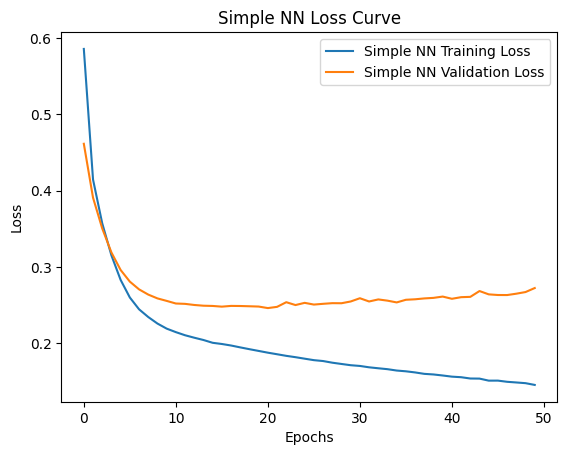

Training NN with L2 Regularization...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


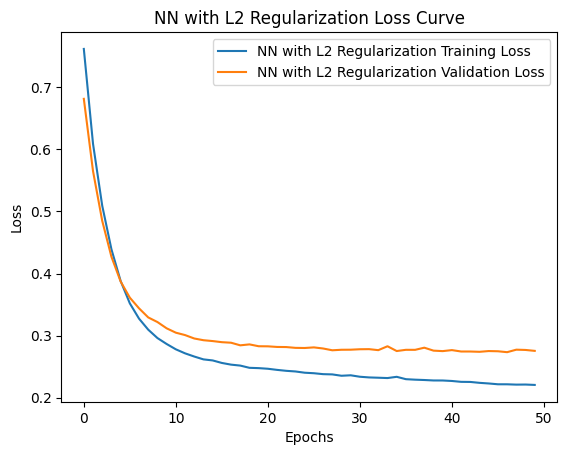

Training NN with Dropout...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


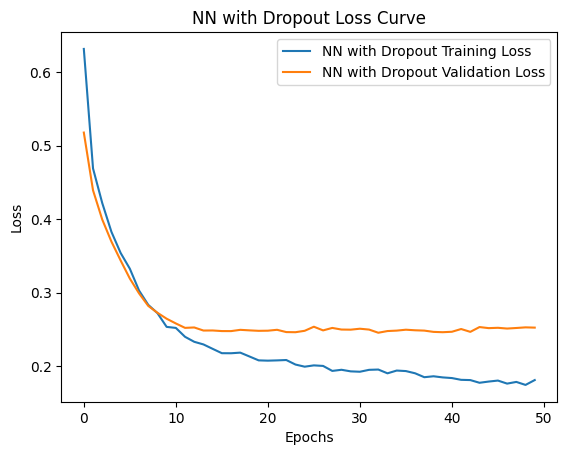

Training NN with Early Stopping...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


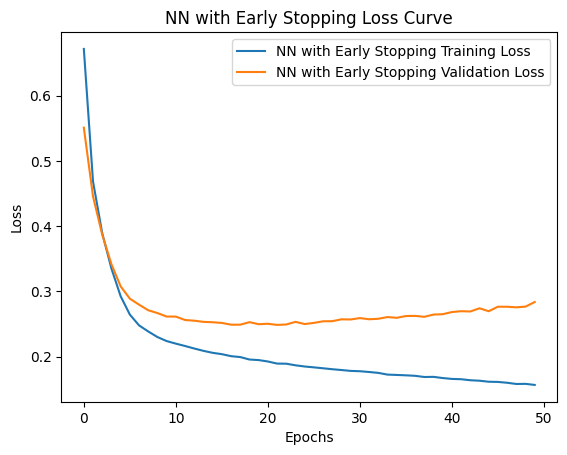

Training NN with L2 + Dropout + Early Stopping...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


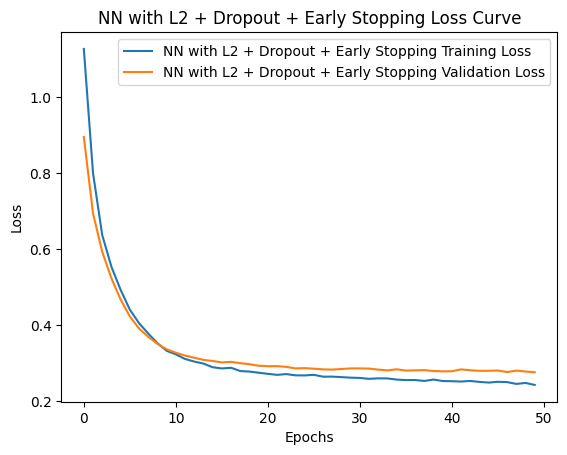

In [ ]:
# Create and evaluate neural network models
nn_models = {
    "Simple NN": create_nn_model(),
    "NN with L2 Regularization": create_nn_model(regularizer=l2(0.01)),
    "NN with Dropout": create_nn_model(dropout_rate=0.2),
    "NN with Early Stopping": create_nn_model(early_stopping=True),
    "NN with L2 + Dropout + Early Stopping": create_nn_model(regularizer=l2(0.01), dropout_rate=0.2, early_stopping=True)
}

nn_results = {}
for name, model in nn_models.items():
    print(f"Training {name}...")
    history, metrics = train_and_evaluate_nn_model(model, X_train, y_train, X_test, y_test, "early_stopping" in name)
    nn_results[name] = metrics
    plt.plot(history.history["loss"], label=f"{name} Training Loss")
    plt.plot(history.history["val_loss"], label=f"{name} Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{name} Loss Curve")
    plt.legend()
    plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create directory for saving models
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Load dataset
data = pd.read_csv("/content/School_dataset.csv")

# Preprocessing
X = data.drop(columns=['Target'])
y = data['Target']

# Encoding categorical target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = MinMaxScaler()  #
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Compute class weights for handling imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Neural Network Model
def create_nn():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')  # Softmax for multiclass
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
nn_model = create_nn()
nn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1, class_weight=class_weights_dict)

# Save the trained model
nn_model.save(os.path.join(MODEL_DIR, "nn_model.h5"))

# Make predictions
y_pred = nn_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute and print metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average="weighted"),
    "Recall": recall_score(y_test, y_pred, average="weighted"),
    "F1-Score": f1_score(y_test, y_pred, average="weighted")
}

model_name = "Neural Network Model"
print(f"{model_name}: Accuracy={metrics['Accuracy']:.4f}, Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1-Score={metrics['F1-Score']:.4f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5076 - loss: 1.0118 - val_accuracy: 0.6497 - val_loss: 0.7886
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6328 - loss: 0.8317 - val_accuracy: 0.6709 - val_loss: 0.7384
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6686 - loss: 0.7926 - val_accuracy: 0.7274 - val_loss: 0.6688
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6913 - loss: 0.7593 - val_accuracy: 0.6893 - val_loss: 0.6916
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7051 - loss: 0.7375 - val_accuracy: 0.7316 - val_loss: 0.6588
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7171 - loss: 0.7043 - val_accuracy: 0.7288 - val_loss: 0.6505
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7372 - loss: 0.6717 - val_accuracy: 0.7444 - val_loss: 0.6257
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7434 - loss: 0.7033 - val_accuracy: 0.7246 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network Model: Accuracy=0.7153, Precision=0.7552, Recall=0.7153, F1-Score=0.7262
